In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.4.1'

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14109046780236086452
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14458421248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2183475192373655065
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices()))

Num GPUs Available:  2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 2 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [12]:
import pandas as pd
import numpy as np
import math
import nltk

from nltk.stem import WordNetLemmatizer 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack as sp_hstack, vstack as sp_vstack
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.linear_model import LinearRegression

from joblib import Parallel, delayed

import time

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, Callback

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
dataset_train = pd.read_csv('/content/drive/MyDrive/HPC/NSE-TATAGLOBAL.csv')
training_set = dataset_train.iloc[:, 1:2].values

In [14]:
dataset_train.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [15]:
training_set

array([[234.05],
       [234.55],
       [240.  ],
       ...,
       [121.8 ],
       [120.3 ],
       [122.1 ]])

In [16]:
training_set.shape

(2035, 1)

In [17]:
training_set =  pd.DataFrame(training_set)

In [18]:
training_set.head()

,0
0,234.05
1,234.55
2,240.00
3,233.30
4,233.55


In [19]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [20]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [22]:
y_train.head()

,0
0,0.770073
1,0.736415
2,0.737632
3,0.746148
4,0.744931


In [23]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0.620235,0.622263,0.644363,0.617194,0.618208,0.624088,0.627940,0.635848,0.616586,0.577251,0.548459,0.573398,0.573398,0.567315,0.579481,0.571371,0.637064,0.628143,0.632198,0.625507,0.619424,0.632198,0.611111,0.622060,0.645580,0.672344,0.660584,0.647607,0.628345,0.624088,0.615977,0.633414,0.630779,0.633212,0.648418,0.624696,0.628143,0.613950,0.679643,0.658151,0.659367,0.648418,0.627737,0.678832,0.660584,0.639903,0.608881,0.643147,0.678427,0.650649,0.716951,0.745742,0.767640,0.785483,0.789943,0.758921,0.765207,0.796229,0.810624,0.743715
1,0.622263,0.644363,0.617194,0.618208,0.624088,0.627940,0.635848,0.616586,0.577251,0.548459,0.573398,0.573398,0.567315,0.579481,0.571371,0.637064,0.628143,0.632198,0.625507,0.619424,0.632198,0.611111,0.622060,0.645580,0.672344,0.660584,0.647607,0.628345,0.624088,0.615977,0.633414,0.630779,0.633212,0.648418,0.624696,0.628143,0.613950,0.679643,0.658151,0.659367,0.648418,0.627737,0.678832,0.660584,0.639903,0.608881,0.643147,0.678427,0.650649,0.716951,0.745742,0.767640,0.785483,0.789943,0.758921,0.765207,0.796229,0.810624,0.743715,0.770073
2,0.644363,0.617194,0.618208,0.624088,0.627940,0.635848,0.616586,0.577251,0.548459,0.573398,0.573398,0.567315,0.579481,0.571371,0.637064,0.628143,0.632198,0.625507,0.619424,0.632198,0.611111,0.622060,0.645580,0.672344,0.660584,0.647607,0.628345,0.624088,0.615977,0.633414,0.630779,0.633212,0.648418,0.624696,0.628143,0.613950,0.679643,0.658151,0.659367,0.648418,0.627737,0.678832,0.660584,0.639903,0.608881,0.643147,0.678427,0.650649,0.716951,0.745742,0.767640,0.785483,0.789943,0.758921,0.765207,0.796229,0.810624,0.743715,0.770073,0.736415
3,0.617194,0.618208,0.624088,0.627940,0.635848,0.616586,0.577251,0.548459,0.573398,0.573398,0.567315,0.579481,0.571371,0.637064,0.628143,0.632198,0.625507,0.619424,0.632198,0.611111,0.622060,0.645580,0.672344,0.660584,0.647607,0.628345,0.624088,0.615977,0.633414,0.630779,0.633212,0.648418,0.624696,0.628143,0.613950,0.679643,0.658151,0.659367,0.648418,0.627737,0.678832,0.660584,0.639903,0.608881,0.643147,0.678427,0.650649,0.716951,0.745742,0.767640,0.785483,0.789943,0.758921,0.765207,0.796229,0.810624,0.743715,0.770073,0.736415,0.737632
4,0.618208,0.624088,0.627940,0.635848,0.616586,0.577251,0.548459,0.573398,0.573398,0.567315,0.579481,0.571371,0.637064,0.628143,0.632198,0.625507,0.619424,0.632198,0.611111,0.622060,0.645580,0.672344,0.660584,0.647607,0.628345,0.624088,0.615977,0.633414,0.630779,0.633212,0.648418,0.624696,0.628143,0.613950,0.679643,0.658151,0.659367,0.648418,0.627737,0.678832,0.660584,0.639903,0.608881,0.643147,0.678427,0.650649,0.716951,0.745742,0.767640,0.785483,0.789943,0.758921,0.765207,0.796229,0.810624,0.743715,0.770073,0.736415,0.737632,0.746148


In [24]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_csv('/content/drive/MyDrive/HPC/tatatest.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [25]:
# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [26]:
real_stock_price = sc.fit_transform(real_stock_price)

In [27]:
X_test = pd.DataFrame(X_test)

In [28]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,0.206002,0.216545,0.216545,0.217559,0.198702,0.190187,0.178021,0.175588,0.163017,0.167072,0.171127,0.176399,0.183496,0.171736,0.164234,0.169911,0.176196,0.167883,0.169100,0.173966,0.177413,0.182685,0.192214,0.188970,0.190187,0.173966,0.170925,0.167883,0.174777,0.164436,0.145580,0.152879,0.153690,0.150446,0.141525,0.151460,0.133414,0.125304,0.117194,0.117802,0.124899,0.141322,0.130981,0.129359,0.132401,0.128954,0.125304,0.133820,0.145580,0.151663,0.150852,0.146796,0.143552,0.127332,0.149635,0.148013,0.158151,0.165045,0.158962,0.166261
1,0.216545,0.216545,0.217559,0.198702,0.190187,0.178021,0.175588,0.163017,0.167072,0.171127,0.176399,0.183496,0.171736,0.164234,0.169911,0.176196,0.167883,0.169100,0.173966,0.177413,0.182685,0.192214,0.188970,0.190187,0.173966,0.170925,0.167883,0.174777,0.164436,0.145580,0.152879,0.153690,0.150446,0.141525,0.151460,0.133414,0.125304,0.117194,0.117802,0.124899,0.141322,0.130981,0.129359,0.132401,0.128954,0.125304,0.133820,0.145580,0.151663,0.150852,0.146796,0.143552,0.127332,0.149635,0.148013,0.158151,0.165045,0.158962,0.166261,0.563666
2,0.216545,0.217559,0.198702,0.190187,0.178021,0.175588,0.163017,0.167072,0.171127,0.176399,0.183496,0.171736,0.164234,0.169911,0.176196,0.167883,0.169100,0.173966,0.177413,0.182685,0.192214,0.188970,0.190187,0.173966,0.170925,0.167883,0.174777,0.164436,0.145580,0.152879,0.153690,0.150446,0.141525,0.151460,0.133414,0.125304,0.117194,0.117802,0.124899,0.141322,0.130981,0.129359,0.132401,0.128954,0.125304,0.133820,0.145580,0.151663,0.150852,0.146796,0.143552,0.127332,0.149635,0.148013,0.158151,0.165045,0.158962,0.166261,0.563666,0.567721
3,0.217559,0.198702,0.190187,0.178021,0.175588,0.163017,0.167072,0.171127,0.176399,0.183496,0.171736,0.164234,0.169911,0.176196,0.167883,0.169100,0.173966,0.177413,0.182685,0.192214,0.188970,0.190187,0.173966,0.170925,0.167883,0.174777,0.164436,0.145580,0.152879,0.153690,0.150446,0.141525,0.151460,0.133414,0.125304,0.117194,0.117802,0.124899,0.141322,0.130981,0.129359,0.132401,0.128954,0.125304,0.133820,0.145580,0.151663,0.150852,0.146796,0.143552,0.127332,0.149635,0.148013,0.158151,0.165045,0.158962,0.166261,0.563666,0.567721,0.601582
4,0.198702,0.190187,0.178021,0.175588,0.163017,0.167072,0.171127,0.176399,0.183496,0.171736,0.164234,0.169911,0.176196,0.167883,0.169100,0.173966,0.177413,0.182685,0.192214,0.188970,0.190187,0.173966,0.170925,0.167883,0.174777,0.164436,0.145580,0.152879,0.153690,0.150446,0.141525,0.151460,0.133414,0.125304,0.117194,0.117802,0.124899,0.141322,0.130981,0.129359,0.132401,0.128954,0.125304,0.133820,0.145580,0.151663,0.150852,0.146796,0.143552,0.127332,0.149635,0.148013,0.158151,0.165045,0.158962,0.166261,0.563666,0.567721,0.601582,0.605028


In [29]:
y_test =  pd.DataFrame(real_stock_price)

In [30]:
reg = LinearRegression()

In [31]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
reg.score(X_train, y_train)

0.9948181326993625

In [33]:
import numpy as np
from sklearn import linear_model
from sklearn import svm

In [34]:
SGD_Regressor = linear_model.SGDRegressor()
SGD_Regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [35]:
SGD_Regressor.score(X_train, y_train)

0.9600352354654871

In [36]:
Bayesian_Ridge = linear_model.BayesianRidge()
Bayesian_Ridge.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [37]:
Bayesian_Ridge.score(X_train, y_train)

0.9948129269374403

In [38]:
Lasso_Lars = linear_model.LassoLars()
Lasso_Lars.fit(X_train, y_train)

LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False)

In [39]:
Lasso_Lars.score(X_train, y_train)

0.0

In [40]:
ARD_Regression = linear_model.ARDRegression()
ARD_Regression.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)

In [41]:
ARD_Regression.score(X_train, y_train)

0.9947114532830363

In [42]:
TheilSen_Regressor = linear_model.TheilSenRegressor()
TheilSen_Regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
                  max_subpopulation=10000, n_jobs=None, n_subsamples=None,
                  random_state=None, tol=0.001, verbose=False)

In [43]:
TheilSen_Regressor.score(X_train, y_train)

0.9946540718041161

In [44]:
y_test.head()

,0
0,0.407407
1,0.441077
2,0.722222
3,0.750842
4,1.000000


In [ ]:
# y_test

In [ ]:
models = [reg, SGD_Regressor, Bayesian_Ridge,Lasso_Lars, ARD_Regression, TheilSen_Regressor]

def fit_and_evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    probs = model.predict(x_val)
    score = model.score(x_val, y_val)
    return probs, score

start_ensemble = time.time()
results = []
for model in models:
    results.append(fit_and_evaluate_model(model, X_train, y_train, X_test, y_test))
end_ensemble = time.time()
time_ensemble_seq = end_ensemble - start_ensemble
print('Time taken by sequential run of ensemble model: {} seconds'.format(time_ensemble_seq))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Time taken by sequential run of ensemble model: 56.51558971405029 seconds


In [ ]:
models_name = ["Linear-Regression", "SGD-Regressor", "Bayesian-Ridge" , "Lasso-Lars", "ARD-Regression", "TheilSen-Regressor"]

In [ ]:
len(results )

6

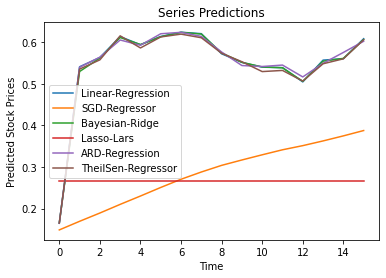

In [ ]:
import matplotlib.pyplot as plt
ind = 0
for i in results:
  plt.plot(i[0], label = models_name[ind])
  ind = ind+1
plt.title("Series Predictions")
plt.xlabel('Time')
plt.ylabel('Predicted Stock Prices')
plt.legend()
plt.show()

In [ ]:

start_ensemble = time.time()
results = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(fit_and_evaluate_model)(model, X_train, y_train, X_test, y_test) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 50.017308473587036 seconds


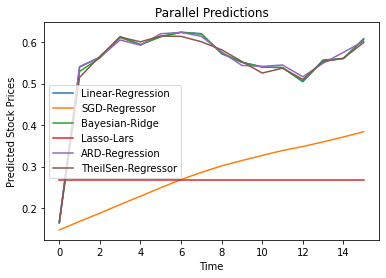

In [ ]:
import matplotlib.pyplot as plt
ind = 0
for i in results:
  plt.plot(i[0], label = models_name[ind])
  ind = ind+1
plt.title("Parallel Predictions")
plt.xlabel('Time')
plt.ylabel('Predicted Stock Prices')
plt.legend()
plt.show()

In [ ]:

start_ensemble = time.time()
results = Parallel(n_jobs=3, backend='multiprocessing', verbose=0)\
                            (delayed(fit_and_evaluate_model)(model, X_train, y_train, X_test, y_test) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Time taken by parallel run of ensemble model: 57.56380796432495 seconds


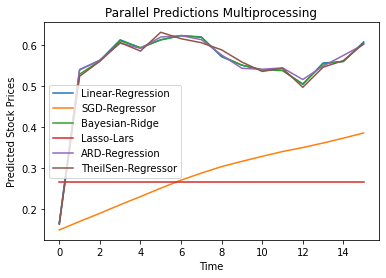

In [ ]:
import matplotlib.pyplot as plt
ind = 0
for i in results:
  plt.plot(i[0], label = models_name[ind])
  ind = ind+1
plt.title("Parallel Predictions Multiprocessing")
plt.xlabel('Time')
plt.ylabel('Predicted Stock Prices')
plt.legend()
plt.show()

In [ ]:

start_ensemble = time.time()
results = Parallel(n_jobs=3, backend='threading', verbose=0)\
                            (delayed(fit_and_evaluate_model)(model, X_train, y_train, X_test, y_test) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Time taken by parallel run of ensemble model: 56.52783823013306 seconds


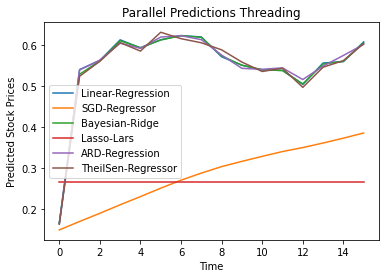

In [ ]:
import matplotlib.pyplot as plt
ind = 0
for i in results:
  plt.plot(i[0], label = models_name[ind])
  ind = ind+1
plt.title("Parallel Predictions Threading")
plt.xlabel('Time')
plt.ylabel('Predicted Stock Prices')
plt.legend()
plt.show()

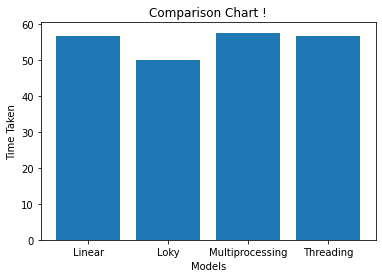

In [ ]:
import matplotlib.pyplot as plt

left = ["Linear", "Loky", "Multiprocessing", "Threading"]
height = [56.51558971405029,50.017308473587036, 57.56380796432495,  56.52783823013306]
  
plt.bar( left,height,width = 0.8)
  
plt.xlabel('Models')
# naming the y-axis
plt.ylabel('Time Taken')
# plot title
plt.title('Comparison Chart !')
  
# function to show the plot
plt.show()

In [45]:
models = [reg, SGD_Regressor, Bayesian_Ridge,Lasso_Lars, ARD_Regression, TheilSen_Regressor]

def fit_and_evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    probs = model.predict(x_val)
    score = model.score(x_val, y_val)
    return probs, score


start_ensemble = time.time()
results = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(fit_and_evaluate_model)(model, X_train, y_train, X_test, y_test) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 64.88349223136902 seconds


In [149]:
arr = []
mid = []
for i in results[0][0]:
  mid.append(i[0])
arr.append(mid)

In [150]:
for i in results[1:]:
  mid=[]
  for j in i[0]:
    mid.append(j)
  arr.append(mid)

In [151]:
len(arr)

6

In [152]:
weights = []
for i in results:
  weights.append(i[1])
weights

[0.1248547608267685,
 -1.0285979050206118,
 0.12346979343788012,
 -0.9759393087233275,
 0.11964202935101209,
 0.11747694208650472]

In [153]:
y_test_list = list(y_test[0])

In [51]:
def simple_average(real ,weights , arr ):
  final = []
  for i in range(4,len(real)):
    before = real[i-1]
    t,f = 0,0
    for j in arr:
      s=sum(j[i-4:i+1])/5
      if(s>before):
        t=t+1
      else:
        f=f+1
    if(t>f):
      final.append("Buy")
    else:
      final.append("Don't Buy")  
  return(final)

In [66]:
# start_ensemble = time.time()
simple_average(y_test_list, weights, arr)
# end_ensemble = time.time()
# time_ensemble_par = end_ensemble - start_ensemble
# time_ensemble_par

["Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 "Don't Buy"]

In [56]:
!pip install pymp-pypi

In [55]:
import pymp

In [73]:
def simple_average_parallel(real ,weights , arr ):
  final = []
  with pymp.Parallel(2) as p:
      for i in p.xrange(4,len(real)+1):
        before = real[i-1]
        t,f = 0,0
        for j in arr:
          with p.lock:
            s=sum(j[i-4:i+1])/5
            if(s>before):
              t=t+1
            else:
              f=f+1
        if(t>f):
          final.append("Buy")
        else:
          final.append("Don't Buy")  
  return(final)

In [74]:
# start_ensemble = time.time()
simple_average_parallel(y_test_list, weights, arr)
# end_ensemble = time.time()
# time_ensemble_par = end_ensemble - start_ensemble
# time_ensemble_par

["Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy']

In [78]:
def weighted_average(real ,weights , arr ):
  final = []
  copy = [0]*len(weights)

  # Calculating Weights
  for i in range(len(weights)) :
    m = weights.index(min(weights))
    copy[m] = i+1

  for i in range(4,len(real)):
    before = real[i-1]
    t,f,ind = 0,0,0

    for j in arr:
      s=sum(j[i-4:i+1])/5
      if(s>before):
        t=t+(1*copy[ind])
      else:
        f=f+(1*copy[ind])
      ind = ind + 1
    if(t>f):
      final.append("Buy")
    else:
      final.append("Don't Buy")  
  return(final)

In [79]:
weighted_average(y_test_list, weights, arr)

["Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 "Don't Buy",
 "Don't Buy"]

In [80]:
def weighted_average_parallel(real ,weights , arr ):
  final = []
  copy = [0]*len(weights)

  # Calculating Weights
  
  for i in range(len(weights)) :
    m = weights.index(min(weights))
    copy[m] = i+1

  with pymp.Parallel(2) as p:
    for i in range(4,len(real)):
      before = real[i-1]
      t,f,ind = 0,0,0

      for j in arr:
        with p.lock:
          s=sum(j[i-4:i+1])/5
          if(s>before):
            t=t+(1*copy[ind])
          else:
            f=f+(1*copy[ind])
          ind = ind + 1
      if(t>f):
        final.append("Buy")
      else:
        final.append("Don't Buy")  
  return(final)

In [81]:
weighted_average_parallel(y_test_list, weights, arr)

["Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 "Don't Buy",
 "Don't Buy"]

In [82]:
def exponential_average(real ,weights , arr ):
  final = []
  copy = [0]*len(weights)

  # Calculating Weights
  for i in range(len(weights)) :
    m = weights.index(min(weights))
    copy[m] = i+1

  for i in range(4,len(real)):
    before = real[i-1]
    t,f,ind = 0,0,0
    for j in arr:
      s=0
      exp = [0.1,0.2,0.3,0.4,0.5]
      ide = 0
      for k in j[i-4:i+1] :
        s=s + k*(exp[ide])
        ide = ide+1
      s=s/1.5
      if(s>before):
        t=t+(1*copy[ind])
      else:
        f=f+(1*copy[ind])
      ind = ind + 1
    if(t>f):
      final.append("Buy")
    else:
      final.append("Don't Buy")  
  return(final)

In [83]:
exponential_average(y_test_list, weights, arr)

["Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 "Don't Buy",
 "Don't Buy"]

In [86]:
def exponential_average_parallel(real ,weights , arr ):
  final = []
  copy = [0]*len(weights)

  # Calculating Weights
  for i in range(len(weights)) :
    m = weights.index(min(weights))
    copy[m] = i+1
  with pymp.Parallel(2) as p:
    for i in range(4,len(real)):
      before = real[i-1]
      t,f,ind = 0,0,0
      for j in arr:
        with p.lock:
          s=0
          exp = [0.1,0.2,0.3,0.4,0.5]
          ide = 0
          for k in j[i-4:i+1] :
            s=s + k*(exp[ide])
            ide = ide+1
          s=s/1.5
          if(s>before):
            t=t+(1*copy[ind])
          else:
            f=f+(1*copy[ind])
          ind = ind + 1
      if(t>f):
        final.append("Buy")
      else:
        final.append("Don't Buy")  
  return(final)

In [88]:
exponential_average_parallel(y_test_list, weights, arr)

["Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 "Don't Buy",
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 'Buy',
 "Don't Buy",
 "Don't Buy"]

# Serial Functions 

In [98]:
#Serial_Implementation-Serial_Functions

In [99]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = []
for model in models:
    results_buy.append(model(y_test_list, weights, arr))
end_ensemble = time.time()
time_ensemble_seq = end_ensemble - start_ensemble
print('Time taken by sequential run of ensemble model: {} seconds'.format(time_ensemble_seq))

Time taken by sequential run of ensemble model: 0.0008313655853271484 seconds


In [102]:
#Parallel_Implementation_Loky-Serial_Functions

In [103]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 0.06517839431762695 seconds


In [104]:
#Parallel_Implementation_Multi-Serial_Functions

In [105]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='multiprocessing', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 0.4046664237976074 seconds


In [106]:
#Parallel_Implementation_Threading-Serial_Functions

In [107]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='threading', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 0.10668087005615234 seconds


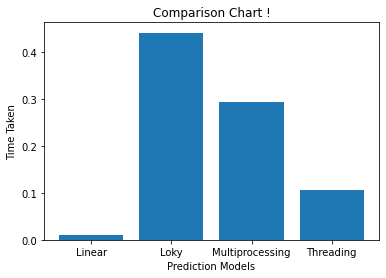

In [ ]:
import matplotlib.pyplot as plt

left = ["Linear", "Loky", "Multiprocessing", "Threading"]
height = [0.009655475616455078, 0.4409363269805908, 0.2941441535949707, 0.10568904876708984]
  
plt.bar( left,height,width = 0.8)
  
plt.xlabel('Prediction Models')
# naming the y-axis
plt.ylabel('Time Taken')
# plot title
plt.title('Comparison Chart !')
  
# function to show the plot
plt.show()

# Serial Functions with Extended Data

In [ ]:
y_test_list = y_test_list*10

In [ ]:
for i in range(len(arr)):
  arr[i] = arr[i]*10

In [ ]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = []
for model in models:
    results_buy.append(model(y_test_list, weights, arr))
end_ensemble = time.time()
time_ensemble_seq = end_ensemble - start_ensemble
print('Time taken by sequential run of ensemble model: {} seconds'.format(time_ensemble_seq))

Time taken by sequential run of ensemble model: 4.837552309036255 seconds


In [ ]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 9.369730472564697 seconds


In [ ]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='multiprocessing', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 5.101279258728027 seconds


In [ ]:
models = [simple_average, weighted_average, exponential_average]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='threading', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 4.797720909118652 seconds


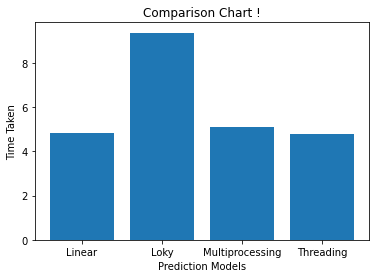

In [ ]:
import matplotlib.pyplot as plt

left = ["Linear", "Loky", "Multiprocessing", "Threading"]
height = [4.837552309036255, 9.369730472564697, 5.101279258728027,  4.797720909118652]
  
plt.bar( left,height,width = 0.8)
  
plt.xlabel('Prediction Models')
# naming the y-axis
plt.ylabel('Time Taken')
# plot title
plt.title('Comparison Chart !')
  
# function to show the plot
plt.show()

# Parallel Functions

In [154]:
models = [simple_average_parallel, weighted_average_parallel, exponential_average_parallel]

start_ensemble = time.time()
results_buy = []
for model in models:
    results_buy.append(model(y_test_list, weights, arr))
end_ensemble = time.time()
time_ensemble_seq = end_ensemble - start_ensemble
print('Time taken by sequential run of ensemble model: {} seconds'.format(time_ensemble_seq))

Time taken by sequential run of ensemble model: 0.34371018409729004 seconds


In [155]:
#Parallel_Implementation_Loky-Parallel_Functions

In [157]:
models = [simple_average_parallel, weighted_average_parallel, exponential_average_parallel]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 0.7457356452941895 seconds


In [ ]:
#Parallel_Implementation_Multi-Parallel_Functions

In [158]:
models = [simple_average_parallel, weighted_average_parallel, exponential_average_parallel]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='multiprocessing', verbose=0)\
                            (delayed(model)(y_test_list, weights, arr) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 0.5589661598205566 seconds


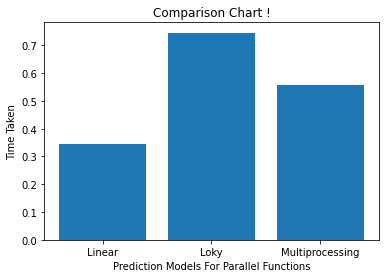

In [159]:
import matplotlib.pyplot as plt

left = ["Linear", "Loky", "Multiprocessing"]
height = [0.34371018409729004,  0.7457356452941895  , 0.5589661598205566]
  
plt.bar( left,height,width = 0.8)
  
plt.xlabel('Prediction Models For Parallel Functions')
# naming the y-axis
plt.ylabel('Time Taken')
# plot title
plt.title('Comparison Chart !')
  
# function to show the plot
plt.show()

# Parallel Functions with extended data

In [ ]:
arr_copy = arr
y_test_list_copy = y_test_list

In [ ]:
y_test_list_copy = y_test_list_copy*10

In [ ]:
for i in range(len(arr_copy)):
  arr_copy[i] = arr_copy[i]*10

In [ ]:
#Serial_Implementation-Parallel_Functions

In [ ]:
models = [simple_average_parallel, weighted_average_parallel, exponential_average_parallel]

start_ensemble = time.time()
results_buy = []
for model in models:
    results_buy.append(model(y_test_list_copy, weights, arr_copy))
end_ensemble = time.time()
time_ensemble_seq = end_ensemble - start_ensemble
print('Time taken by sequential run of ensemble model: {} seconds'.format(time_ensemble_seq))

Time taken by sequential run of ensemble model: 14.77927851676941 seconds


In [ ]:
#Parallel_Implementation_Loky-Parallel_Functions

In [ ]:
models = [simple_average_parallel, weighted_average_parallel, exponential_average_parallel]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(model)(y_test_list_copy, weights, arr_copy) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 8.956387519836426 seconds


In [ ]:
#Parallel_Implementation_Multi-Parallel_Functions

In [ ]:
models = [simple_average_parallel, weighted_average_parallel, exponential_average_parallel]

start_ensemble = time.time()
results_buy = Parallel(n_jobs=3, backend='multiprocessing', verbose=0)\
                            (delayed(model)(y_test_list_copy, weights, arr_copy) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 13.621339082717896 seconds


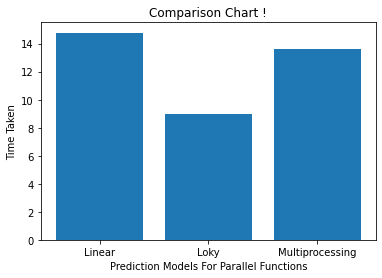

In [146]:
import matplotlib.pyplot as plt

left = ["Linear", "Loky", "Multiprocessing"]
height = [14.77927851676941, 8.956387519836426 , 13.621339082717896]
  
plt.bar( left,height,width = 0.8)
  
plt.xlabel('Prediction Models For Parallel Functions')
# naming the y-axis
plt.ylabel('Time Taken')
# plot title
plt.title('Comparison Chart !')
  
# function to show the plot
plt.show()